## 1. Executive Summary

## 2. Narrative-Driven Analysis

## 3. Data Retrieval

All datasets used in this exploratory analysis were obtained using the official data retrieval script provided by the project sponsor:

https://github.com/TrilemmaFoundation/bitcoin-analytics-capstone-template/blob/main/data/download_data.py

The script was executed from the repository root using Anaconda Prompt, which downloads the sponsor-managed Google Drive folder and organizes all usable files into a local `data/` directory while preserving the original subfolder structure. Only approved file types (`.parquet`, `.csv`, `.md`) are retained.

To keep this notebook lightweight and fully deterministic, we do not re-run the download step here. Instead, we assume the data have already been retrieved once using the official pipeline and only verify the expected directory structure before proceeding with exploratory analysis.

In [11]:
import os
from pathlib import Path

# ---- Set repo root explicitly ----
REPO_ROOT = Path(r"C:\Users\chen5\Documents\bitcoin-analytics-capstone")
os.chdir(REPO_ROOT)

print("Current working directory:")
print(os.getcwd())

# ---- Define data path ----
DATA_DIR = REPO_ROOT / "data"
print("Data directory exists:", DATA_DIR.exists())

# ---- Dataset-specific paths ----
COINMETRICS_PATH = DATA_DIR / "Coin Metrics" / "coinmetrics_btc.csv"
POLYMARKET_DIR = DATA_DIR / "Polymarket"

print("Coin Metrics file exists:", COINMETRICS_PATH.exists())
print("Polymarket dir exists:", POLYMARKET_DIR.exists())


Current working directory:
C:\Users\chen5\Documents\bitcoin-analytics-capstone
Data directory exists: True
Coin Metrics file exists: True
Polymarket dir exists: True


## 4. General Overview

This section provides a high-level overview of the datasets used in this exploratory analysis. The goal is to validate coverage and basic structure before conducting focused exploration.

Two sponsor-provided data sources are used:

- **Coin Metrics**: Daily Bitcoin market and on-chain metrics  
- **Polymarket**: Prediction market data for finance- and politics-related events


### 4.1 Coin Metrics: Bitcoin Market Baseline & Structural Context

Bitcoin market and on-chain data are sourced from Coin Metrics, a widely used provider of standardized cryptocurrency metrics.

The dataset is reported at a daily cadence (UTC) and spans from **2009-01-03 to 2026-01-14**, covering the full history of Bitcoin across multiple market cycles.
At this stage, the objective is to validate **time coverage, continuity, and high-level structure**, rather than perform feature engineering or predictive analysis.

These checks establish the **baseline market structure** against which any external signal (e.g., prediction market activity) must demonstrate **incremental or orthogonal informational value.**


#### Data Loading & Basic Validation

In [12]:
import pandas as pd

btc_df = pd.read_csv(COINMETRICS_PATH)
btc_df["time"] = pd.to_datetime(btc_df["time"])

print(
    "Rows:", btc_df.shape[0],
    "| Columns:", btc_df.shape[1],
    "| Missing days:",
    len(
        pd.date_range(
            btc_df["time"].min(),
            btc_df["time"].max(),
            freq="D"
        ).difference(btc_df["time"])
    )
)


Rows: 6221 | Columns: 32 | Missing days: 0


**Key checks:**

- The dataset contains 6,221 daily observations  
- The time index is continuous, with no missing calendar days  
- Columns cover price, market capitalization, network activity, and exchange flows  

**Note:** While the date index is fully continuous, some individual metrics contain missing values in early Bitcoin history. Summary statistics are therefore computed column-wise after dropping NaNs.

This confirms that the Coin Metrics data are complete and suitable for downstream exploratory analysis.These checks confirm that the Coin Metrics dataset provides a complete and temporally coherent baseline suitable for downstream exploratory analysis.

#### Value Ranges & Sanity Checks

In [22]:
btc_df[["PriceUSD", "TxCnt", "HashRate"]].describe().round(2)

,PriceUSD,TxCnt,HashRate
count,5659.00,6220.00,6.214000e+03
mean,19809.99,208414.23,1.514551e+08
std,29699.08,170293.82,2.634492e+08
min,0.05,0.00,0.000000e+00
25%,260.58,47152.50,6.284000e+01
50%,5728.35,224415.50,5.567322e+06
75%,28820.68,312607.50,1.652824e+08
max,124824.45,928131.00,1.305500e+09


The observed value ranges are consistent with known Bitcoin market behavior across early, mid, and recent history, further confirming structural validity.

#### Bitcoin Price History (Log Scale)

To establish long-horizon market context, we visualize Bitcoin’s full price history using a logarithmic scale. This highlights regime shifts and long-term growth while preserving early-period dynamics.

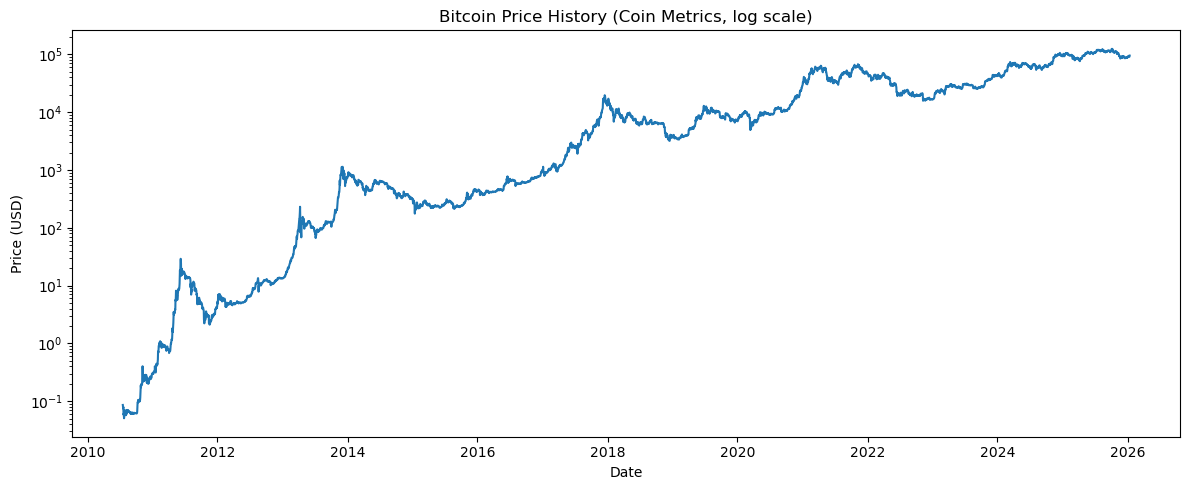

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(btc_df["time"], btc_df["PriceUSD"])
plt.yscale("log")
plt.title("Bitcoin Price History (Coin Metrics, log scale)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.tight_layout()
plt.show()


This visualization reveals Bitcoin’s characteristic multi-cycle structure, with periods of rapid expansion followed by drawdowns and consolidation.

The plot is included solely to establish regime context and is not used directly as a modeling signal.

#### High-Level Correlations Among Core Metrics

As a final structural check, we examine correlations among a small set of core market and network variables. This step provides descriptive context rather than causal inference.


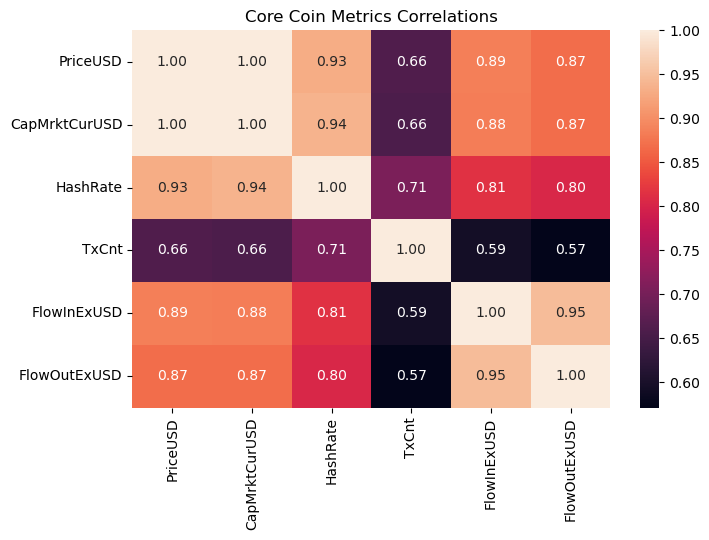

In [15]:
import seaborn as sns

core_cols = [
    "PriceUSD",
    "CapMrktCurUSD",
    "HashRate",
    "TxCnt",
    "FlowInExUSD",
    "FlowOutExUSD",
]
core_cols = [c for c in core_cols if c in btc_df.columns]

corr = btc_df[core_cols].dropna().corr()

plt.figure(figsize=(7.5, 5.5))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.title("Core Coin Metrics Correlations")
plt.tight_layout()
plt.show()


**Observations:**

- Price and market capitalization are nearly perfectly correlated, as expected  
- Hash rate exhibits strong association with long-term price levels  
- Exchange inflows and outflows are tightly correlated with each other  
- Transaction count shows weaker correlation, indicating distinct behavioral dynamics  

These relationships are noted strictly as background context for later, more targeted exploration.


**Section Takeaway**

The Coin Metrics dataset provides a complete, long-horizon view of Bitcoin’s market and on-chain behavior, with consistent daily coverage and well-defined core variables.

This establishes a reliable baseline against which the incremental value of prediction-market-derived signals can be evaluated in subsequent sections.

###  Polymarket: Prediction Market Data

#### Data Loading & Basic Validation

In [16]:
# ---- Load core Polymarket tables ----
pm_markets = pd.read_parquet(POLYMARKET_DIR / "finance_politics_markets.parquet")
pm_odds = pd.read_parquet(POLYMARKET_DIR / "finance_politics_odds_history.parquet")

# ---- Parse market-level timestamps ----
pm_markets["created_at"] = pd.to_datetime(pm_markets["created_at"])
pm_markets["end_date"] = pd.to_datetime(pm_markets["end_date"])

print("Markets table:", pm_markets.shape)
print("Odds history table:", pm_odds.shape)


Markets table: (78321, 10)
Odds history table: (2143181, 4)


#### Structural Integrity Checks

In [17]:
print("Unique markets:", pm_markets["market_id"].nunique())
print("Unique events:", pm_markets["event_slug"].nunique())

pm_odds[["price"]].describe()


Unique markets: 78321
Unique events: 44033


,price
count,2.143181e+06
mean,5.000062e-01
std,3.909961e-01
min,5.000000e-04
25%,6.750000e-02
50%,5.000000e-01
75%,9.325000e-01
max,1.000000e+00


#### Timestamp Anomaly Detection

In [18]:
print(
    "Raw odds time range:",
    pm_odds["timestamp"].min(),
    "→",
    pm_odds["timestamp"].max()
)


Raw odds time range: 1970-01-20 09:08:38.412000 → 1970-01-21 10:59:34.930000


#### Timestamp Correction and Normalization


In [19]:
# ---- Fix odds timestamps (epoch milliseconds) ----
ts_ms = pd.to_numeric(pm_odds["timestamp"], errors="coerce")

pm_odds["timestamp_fixed"] = pd.to_datetime(ts_ms, unit="ms", utc=True)
pm_odds["date"] = pm_odds["timestamp_fixed"].dt.date

print(
    "Fixed odds time range:",
    pm_odds["timestamp_fixed"].min(),
    "→",
    pm_odds["timestamp_fixed"].max()
)
print("Unique days:", pm_odds["date"].nunique())


Fixed odds time range: 2023-01-24 00:00:12+00:00 → 2026-01-05 01:02:10+00:00
Unique days: 1066


#### Odds Update Density

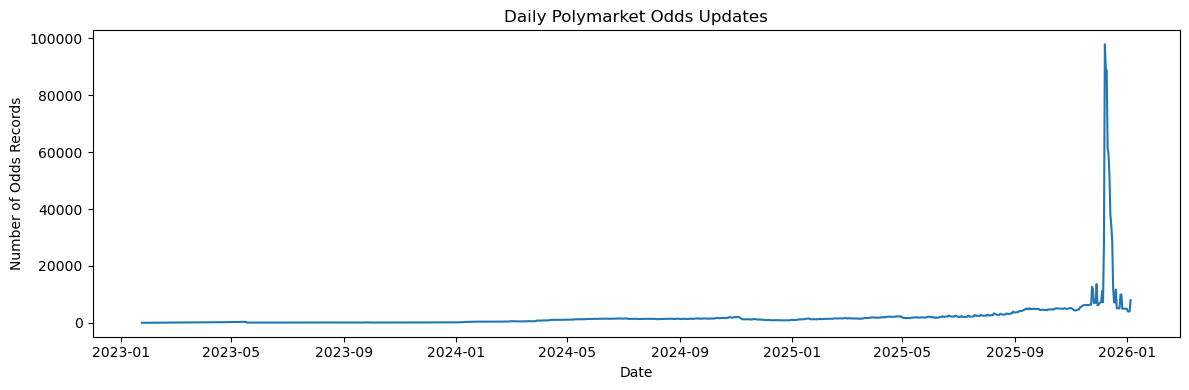

In [20]:
odds_daily = (
    pm_odds
    .groupby("date")
    .size()
)

plt.figure(figsize=(12, 4))
plt.plot(odds_daily.index, odds_daily.values)
plt.title("Daily Polymarket Odds Updates")
plt.xlabel("Date")
plt.ylabel("Number of Odds Records")
plt.tight_layout()
plt.show()
